## Face Detection with SVM

### Load data

In [ ]:
import glob
from skimage.io import imread
import numpy as np
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.externals import joblib
from math import floor
from skimage.draw import polygon_perimeter
import matplotlib.patches as pypatches
from random import randrange
import matplotlib.pyplot as plt
%matplotlib inline

In [1]:
faces_path = "../data/face_detection/cropped_faces/*.pgm"
non_faces_path = "../data/face_detection/non_faces_images/neg_cropped_img/*.png"

def load_classes_paths(faces_path, non_faces_path):
    face_paths = glob.glob(faces_path)
    non_face_paths = glob.glob(non_faces_path)
    
    return face_paths, non_face_paths

face_paths, non_face_paths = load_classes_paths(faces_path, non_faces_path)

print("Number of faces in the dataset: {:d}".format(len(face_paths)))
print("Number of non-faces in the dataset: {:d}".format(len(non_face_paths)))

def load_data_from_paths(face_paths, non_face_paths):
    feats_data, labels_data = [], []
    for path in face_paths:
        feats_data.append(imread(path, as_grey=True))
        labels_data.append(1) # for faces
            
    for path in non_face_paths:
        feats_data.append(imread(path, as_grey=True))
        labels_data.append(0) # for non faces

    X = np.array(feats_data)
    y = np.array(labels_data)
    
    return X, y

X_all, y_all = load_data_from_paths(face_paths, non_face_paths)

assert len(X_all) == len(y_all)

print("Number of elements: {:d}".format(len(X_all)))

Number of faces in the dataset: 7308
Number of non-faces in the dataset: 4902
Number of elements: 12210


### Extract features

In [2]:
# from https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/2b62a1c3-e151-4a0e-b6b6-e424fa46ceab/lessons/fd66c083-4ccb-4fe3-bda1-c29db76f50a0/concepts/d479f43a-7bbb-4de7-9452-f6b991ece599
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=False)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
        return features

def extract_features(image):
   
    # Define HOG parameters
    orient = 9
    pix_per_cell = 8    
    cell_per_block = 2
    
    hog_feats = get_hog_features(
            image, 
            orient, 
            pix_per_cell, 
            cell_per_block, 
            vis=False, 
            feature_vec=True
        )

    return hog_feats

In [3]:
X_feats_all = []
for el in X_all:
    X_feats_all.append(extract_features(el))

X_feats_all = np.array(X_feats_all)

X_train, X_test, y_train, y_test = train_test_split(X_feats_all, y_all, test_size=0.3, random_state=50)

/mnt/linux_shared/shared/anaconda3/envs/icv/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


In [4]:
print("Number of features per image: {:d}".format(X_train.shape[1]))

Number of features per image: 1764


### Train classifier

In [7]:
model = SVC(kernel="linear", C=100.0)
model.fit(X_train, y_train)
model.score(X_test, y_test)

joblib.dump(model, 'svm.pkl')

['svm.pkl']

### Make predictions

In [36]:
def slide_image(image, window_size, stride):
        
    patches = []
    locations = []
    h, w = image.shape
    
    for j in range(0, h - window_size, stride):
        for i in range(0, w - window_size, stride):
            single_patch = image[i:i+window_size, j:j+window_size]
            patches.append(single_patch)
            locations.append([i, j, window_size, window_size])
            
    return patches, locations

In [25]:
def get_random_val_image():
    imgs_path = "../data/face_detection/val_face_detection_images/*.jpg"
    all_paths = glob.glob(imgs_path)
    
    index = randrange(len(all_paths))
    image = imread(all_paths[index], as_grey=True)
    
    return image

def load_clf():
    return joblib.load("svm.pkl")

def predict(clf, patch_image):
    feats = extract_features(patch_image)
    pred = clf.predict(feats.reshape((1, -1)))
    
    return pred

def try_prediction(clf, image):
    patches, locations = slide_image(image, 64, 48)
    
    predictions = []
    
    for patch in patches:
        pred = predict(clf, patch)
        predictions.append(pred)
        
    return locations, predictions

/mnt/linux_shared/shared/anaconda3/envs/icv/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


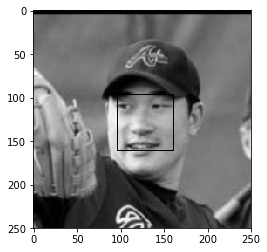

In [34]:
def plot_predictions(clf, image):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.imshow(image, cmap='gray')
    
    locations, predictions = try_prediction(clf, image)
    
    for loc, pred in zip(locations, predictions):
        if pred > 0.9:
            ax.add_patch(pypatches.Rectangle(
                (loc[0], loc[1]),
                loc[2],
                loc[3],
                fill = False                
            )
        )
    
clf = load_clf()
image = get_random_val_image()
plot_predictions(clf, image)